# Tracking Electron Beam from the Time of Arrival (TOA) of Solar Radio Burst

### Download data and configure enviroment

https://github.com/peijin94/SEMP

# Algorithm
(3min reading)

Full paper : https://arxiv.org/abs/1905.09510

The model of the electron beam is a simple 2D parker spiral:

$r=r_0-b(\theta-\theta_0)$


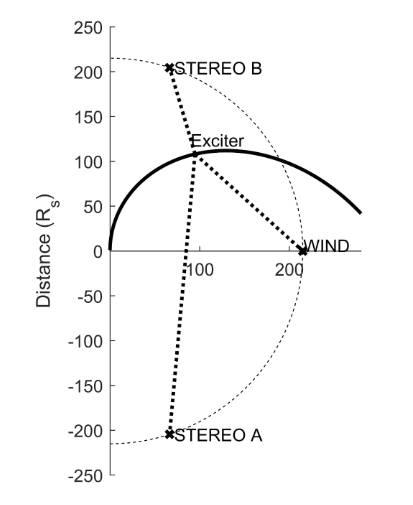


With the modeled trace, we can have the frequency drift curve in the dynamic spectrum:

$		t_{\rm a}(f) = t_0+\frac{S(f)-S(r_0)}{v_{\rm s}}+\frac{d_i(f)}{\rm c}$

where arc length of the trace:

$		S(r)=\frac{r}{2} \sqrt{1+\left(\frac{r}{b}\right)^2 }+\frac{b}{2}  \ln{ \left( \frac{r}{b}+\sqrt{1+\left(\frac{r}{b}\right)^2} \right) } $

and the propagation length:

${d_i (r)}=  \sqrt{(r \cos\theta-R_i \cos \alpha_i )^2+ (r \sin\theta-R_i  \sin\alpha_i  )^2 } ,$

# In practical

Only 2 steps:
* Find and mark Time of Arrival (ToA)
* Use ToA to estimate the trace, with the forward modeling method

## Mark Time of arrival (ToA)

(3min runtime, 10min reading)

In [1]:
import os
import cdflib
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pysemp.pysemp as SEMP
import pysemp

ModuleNotFoundError: No module named 'pysemp'

In [ ]:
fname = './data/20190409/cdf/psp_fld_l2_rfs_hfr_20190409_v01.cdf'
dirdata = './data/20190409/cdf/'

In [2]:
# read data in
year = '2019'    ## must be in YYYY format 
month = '04'     ## Must be in MM format
day = '09'       ## Must be in DD format    
t0 = datetime.datetime(int(year), int(month), int(day))

# hfr
my_fileh12 = pysemp.psp_dataprep.fnames('hfr', year,month,day, 'V1V2', dirdata=dirdata)
my_fileh34 = pysemp.psp_dataprep.fnames('hfr', year,month,day, 'V3V4', dirdata=dirdata)

# extract from cdf file
datah12, epochh12, freqsh12 = pysemp.psp_dataprep.data_from_CDF(t0, my_fileh12)
datah34, epochh34, freqsh34 = pysemp.psp_dataprep.data_from_CDF(t0, my_fileh34)

# lfr
my_filel12 = pysemp.psp_dataprep.fnames('lfr', year,month,day, 'V1V2', dirdata=dirdata)
my_filel34 = pysemp.psp_dataprep.fnames('lfr', year,month,day, 'V3V4', dirdata=dirdata)

# extract from cdf file
datal12, epochl12, freqsl12 = pysemp.psp_dataprep.data_from_CDF(t0, my_filel12)
datal34, epochl34, freqsl34 = pysemp.psp_dataprep.data_from_CDF(t0, my_filel34)

NameError: name 'pysemp' is not defined

In [33]:
# convert time into offset seconds to an anchor time
date = t0.date()
time = datetime.time(hour=12, minute=0, second=0)
dt_anchor = datetime.datetime.combine(date, time)
anchor_time = mdates.date2num(dt_anchor)

sec_epochl12 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochl34 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochh12 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochh34 = (mdates.date2num(epochl12)-anchor_time)*3600*24

# merge
sec_all = (sec_epochl12 + sec_epochh12)/2
idx_range = np.arange(6450,6700)
data_all = np.concatenate(((datal12+datal34)[:,0:56],datah12+datah34),axis=1)
freq_all = np.concatenate((freqsl12[0:56],freqsh12))

In [34]:
# rebin dynamic spectrum for the display
from scipy.interpolate import RegularGridInterpolator

f = RegularGridInterpolator((freq_all,sec_all),data_all.T)

rebin_freq_all=np.logspace(5.5,7.2,150)
rebin_t_all=sec_all
mesh_f, mesh_t = np.meshgrid(rebin_freq_all, rebin_t_all, indexing='ij')
dyspec=f((mesh_f, mesh_t))
rebin_data_all = (dyspec-np.tile(np.mean(dyspec,1).T,(dyspec.shape[1],1)).T).T

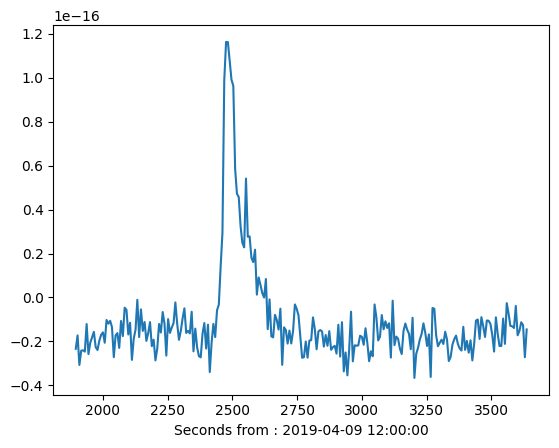

In [35]:
# one light curve
arr_x = (rebin_data_all[idx_range,43])
N_arr_x=arr_x.ravel().shape[0]
idx_x = np.arange(N_arr_x)
x0 = rebin_t_all[idx_range]

ratio_x = 0.7
plt.plot(x0,arr_x)
plt.xlabel('Seconds from : '+str(dt_anchor))
plt.show()

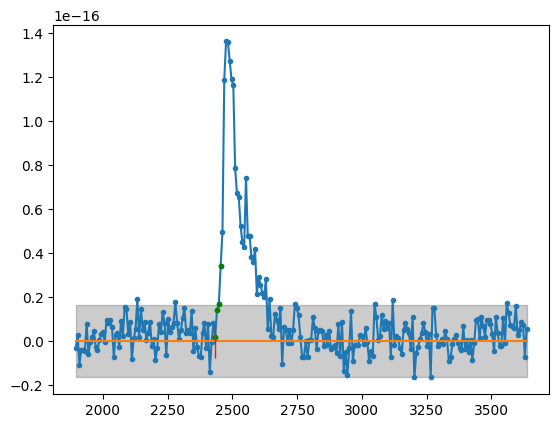

In [36]:
# get leading edge
x_dist = np.partition(arr_x,int(ratio_x*N_arr_x))[:int(ratio_x*N_arr_x)]
avg_d = np.mean(x_dist)
arr_x = arr_x - avg_d
var_d = np.std(x_dist)

cursor_prev = idx_x[np.where(arr_x[0:np.argmax(arr_x)]<var_d*3)][-1]

idx_fit = idx_x[(cursor_prev-1):(cursor_prev+3)]
fit_parm = np.polyfit(x0[idx_fit],arr_x[idx_fit],1)
x_get_this = -fit_parm[1]/fit_parm[0] 

# and plot
plt.plot(x0, arr_x, '.-')
ax = plt.gca()
ax.plot([x0[0],x0[-1]], [0,0])
ax.fill_between([x0[0],x0[-1]], -3*var_d, +3*var_d, color='k', alpha=0.2)
ax.plot(x0[idx_fit], arr_x[idx_fit], 'g.')
ax.plot(x_get_this, 0, 'C3|', zorder=100, markersize=25)

fig = plt.gcf()
#fig.savefig('risePoint.pdf')

In [38]:
# do this for a few channels
selected_idx = np.arange(42, 145, 4)
leading_edge = np.zeros(selected_idx.shape)
for i_n, idx in enumerate(selected_idx):
    freq_this = rebin_freq_all[idx]
    arr_this = (rebin_data_all[idx_range, idx])
    leading_edge[i_n] = SEMP.findLeadingPoint(x0, arr_this, ratio_x=0.8, thresh_std=5)

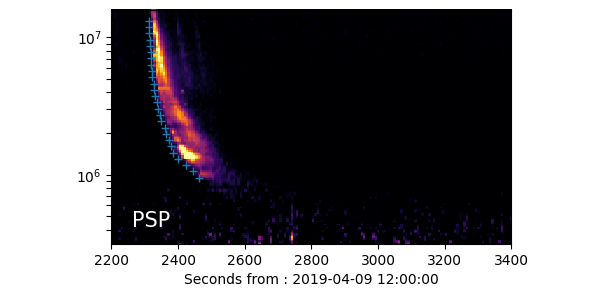

In [39]:
# over plot the dynamic spectrum and the arrival time
from matplotlib.image import NonUniformImage


fig = plt.figure(figsize=(5,3)) 
ax = fig.add_axes([0.15,0.2,0.8,0.78])

#plt.pcolormesh(x0,freqsh34,np.log10(datah34[idx_range,:].T),shading='auto')
im = NonUniformImage(ax, interpolation='nearest', extent=[x0[0],x0[-1], rebin_freq_all[0],rebin_freq_all[-1]], cmap='inferno')
lin_freq = np.linspace(rebin_freq_all[0], rebin_freq_all[-1], rebin_freq_all.shape[0])
im.set_data(x0, lin_freq, (rebin_data_all[idx_range,:].T))
ax.add_image(im)
ax.set_yscale('log')
im.set_clim([0, 3e-16])
ax.set_xlim([2200, 3400])
ax.set_ylim([rebin_freq_all[0], rebin_freq_all[-1]])
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('Seconds from : '+str(dt_anchor))
ax.plot(leading_edge,rebin_freq_all[selected_idx], 'C0+')
ax.yaxis.set_major_locator(plt.LogLocator(base=10, subs='all'))
ax.text(0.1, 0.1, 'PSP', color='w', ha='center', va='center', transform=ax.transAxes, fontsize=15)
#fig.savefig('img/PSP.pdf')
plt.show()

#### then save the ToA results

The next step is, use the ToA of a few spacecraft to

## Estimate a beam electron trace
(4min runntime, 12min reading)



To minimize the loss function:

$D_{\rm total}(t_0,\theta_0,v_{\rm s})= \sqrt{\frac{1}{N}\sum_i \sum_j w_{ij}\left(T_i(f_j)-t_i(f_j)\right)^2} $

(minimize the distance between model and observaiton ToA)


In [11]:
# load the ToA
PSPdataset = np.load('./data/20190409/npz/psp_LE.npz', allow_pickle=True)
WISTAdataset = np.load('./data/20190409/npz/WI_STA_LE.npz')
STAdataset = np.load('./data/20190409/npz/STA_data.npz')
WIdataset = np.load('./data/20190409/npz/WI_data.npz')

freq_PSP = PSPdataset['freq_PSP']
t_PSP = PSPdataset['t_PSP']
freq_WI  = WISTAdataset['freq_WI']*1e3
freq_STA = WISTAdataset['freq_STA']*1e3
t_WI  = WISTAdataset['t_WI']
t_STA = WISTAdataset['t_STA']

data_WI = WIdataset['data_WI']
data_STA = STAdataset['data_STA']
ds_t_WI = WIdataset['ds_t_WI']
ds_f_WI = WIdataset['ds_f_WI']*1e3
ds_t_STA = STAdataset['ds_t_STA']
ds_f_STA = STAdataset['ds_f_STA']*1e3

anchor_dt = PSPdataset['anchor_dt']
data_PSP = PSPdataset['data_PSP']
ds_t_PSP = PSPdataset['ds_t_PSP']
ds_f_PSP = PSPdataset['ds_f_PSP']

# location of the spacecraft
[r_STA, r_WI, r_PSP] = [0.9669, 1.0015*0.99, 0.2266]
[alpha_STA, alpha_WI, alpha_PSP] = np.array([-97.1256, 0, -342.8451])*np.pi/180

In [12]:
# loss function
# x: [t0, theta0, vs]
v_sw = 400
Min_Func = lambda x:(SEMP.Dt_STA_WI_PSP(freq_STA, freq_WI, freq_PSP,
                                        t_STA, t_WI, t_PSP, x[:,0],x[:,1],x[:,2],v_sw,alpha_STA,alpha_WI,
                                        alpha_PSP, r_STA, r_WI, r_PSP, Ne_par=2.0))

In [13]:
# minimize loss function (forward modeling)
import pyswarms

# Set-up hyperparameters
options = {'c1':0.5, 'c2':0.3, 'w':0.9}

# Call instance of GlobalBestPSO
optimizer = pyswarms.single.GlobalBestPSO(n_particles=50, dimensions=3,
                                          options=options, bounds=([0,-0*np.pi,0], [5000,2*np.pi,3e5]))
stats = optimizer.optimize(Min_Func, iters=100)

2023-05-09 12:08:34,082 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|100/100, best_cost=18.5
2023-05-09 12:08:35,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.462484843478375, best pos: [2.13731200e+03 4.56936723e+00 3.51505258e+04]


In [14]:
# compose modeled frequency drifts
f_model = np.logspace(4.5, 7, 30)
t_model_STA = np.zeros(f_model.shape)
t_model_WI = np.zeros(f_model.shape)
t_model_PSP = np.zeros(f_model.shape)

for idx,freq in enumerate(f_model):
    t_model_PSP[idx] = SEMP.t_arrival_model(freq, stats[1][0], stats[1][1], stats[1][2], v_sw=400,alpha=alpha_PSP, r_satellite_AU=r_PSP, Ne_par=2.0)
    t_model_STA[idx] = SEMP.t_arrival_model(freq, stats[1][0], stats[1][1], stats[1][2], v_sw=400,alpha=alpha_STA, r_satellite_AU=r_STA, Ne_par=2.0)
    t_model_WI[idx] = SEMP.t_arrival_model(freq, stats[1][0], stats[1][1], stats[1][2], v_sw=400,alpha=alpha_WI, r_satellite_AU=r_WI, Ne_par=2.0)

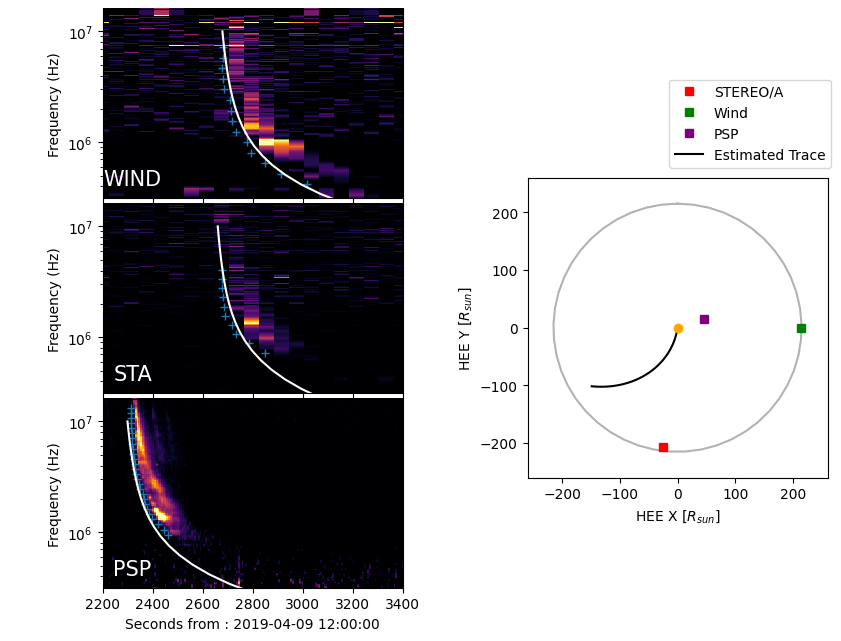

In [15]:
# plot everything
from matplotlib.image import NonUniformImage


fig = plt.figure(figsize=(5,6.5)) 
ax = fig.add_axes([0.15,0.2,0.6,0.29])
ax1 = fig.add_axes([0.15,0.5,0.6,0.29])
ax2 = fig.add_axes([0.15,0.8,0.6,0.29])

ax.set_xlabel('Seconds from : '+str(anchor_dt))

# plot three dynamic spectra
im_list = []
for namethis ,ax_this, ds_t_this, ds_f_this, data_this in zip(['PSP','STA','WIND'],
                                                              [ax,ax1,ax2],
                                                              [ds_t_PSP,ds_t_STA,ds_t_WI],
                                                              [ds_f_PSP,ds_f_STA,ds_f_WI],
                                                              [data_PSP,data_STA,data_WI]):
    im_this = NonUniformImage(ax_this, interpolation='nearest',
                              extent=[ds_t_this[0],ds_t_this[-1], ds_f_this[0],ds_f_this[-1]], cmap='inferno')
    lin_freq = np.linspace(ds_f_this[0], ds_f_this[-1], ds_f_this.shape[0])
    im_this.set_data(ds_t_this, lin_freq, (data_this.T))
    ax_this.add_image(im_this)
    ax_this.set_aspect('auto', 'datalim')
    ax_this.yaxis.set_major_locator(plt.LogLocator(base=10, subs='all'))
    ax_this.text(0.1, 0.1, namethis, color='w', ha='center', va='center', transform=ax_this.transAxes, fontsize=15)
    im_list.append(im_this)
    plt.setp(ax_this, yscale='log', ylabel='Frequency (Hz)', xlim=[2200,3400], ylim=[ds_f_this[0],ds_f_this[-1]])

im_list[0].set_clim([0,3e-16])
im_list[1].set_clim([0,2])
im_list[2].set_clim([0,0.1])

# leading edge points
ax.plot(t_PSP,freq_PSP,'C0+')
ax1.plot(t_STA,freq_STA,'C0+')
ax2.plot(t_WI,freq_WI,'C0+')

# modeled lines
ax.plot(t_model_PSP,f_model,'w')
ax1.plot(t_model_STA,f_model,'w')
ax2.plot(t_model_WI,f_model,'w')

ax1.xaxis.set_ticklabels([]) 
ax2.xaxis.set_ticklabels([]) 

# plot the tracks
ax3 = fig.add_axes([1,0.3,0.6,0.6])

tmp_t = np.linspace(0,2*np.pi)
R_AU = SEMP.AU2km/SEMP.r_sun2km
r_sun2km = SEMP.r_sun2km
ax3.plot(np.sin(tmp_t)*R_AU, np.cos(tmp_t)*R_AU, 'k-', alpha=0.3)
ax3.set_aspect('equal')
markWI,=ax3.plot(r_WI*np.cos(0)*R_AU, r_WI*np.sin(0)*R_AU, 's', color='green', label='Wind')
markSTA,=ax3.plot(r_STA*np.cos(alpha_STA)*R_AU, r_STA*np.sin(alpha_STA)*R_AU, 's', color='red', label='STEREO/A')
markPSP,=ax3.plot(r_PSP*np.cos(alpha_PSP)*R_AU, r_PSP*np.sin(alpha_PSP)*R_AU, 's', color='purple', label='PSP')

r = np.linspace(1,180,100)*r_sun2km
theta_spiral = SEMP.parkerSpiral(r, stats[1][1], v_sw)
markSpiral, = ax3.plot(r*np.cos(theta_spiral)/r_sun2km, r*np.sin(theta_spiral)/r_sun2km, 'k', label='Estimated Trace')

ax3.plot(0, 0, 'o', color='orange')
ax3.set_xlim([-260, 260])
ax3.set_ylim([-260, 260])
ax3.set_xlabel(r'HEE X [$R_{sun}$]')
ax3.set_ylabel(r'HEE Y [$R_{sun}$]')

plt.legend(handles=[markSTA, markWI, markPSP, markSpiral], bbox_to_anchor=(0.45, 1.35), loc='upper left')
#fig.savefig('img/combined.pdf',bbox_inches='tight')
plt.show()